# OTHER MACHINE LEARNING TECHNIQUES

**CONTENTS**

[1. Outliers](#outliers)

[2. Feature scaling](#feature_scaling)

[3. Feature selection](#feature_selection)

[4. Multicolinearity](#multicolinearity)

[5. PCA](#pca)

[6. Feature Engineering](#feature_engineering)


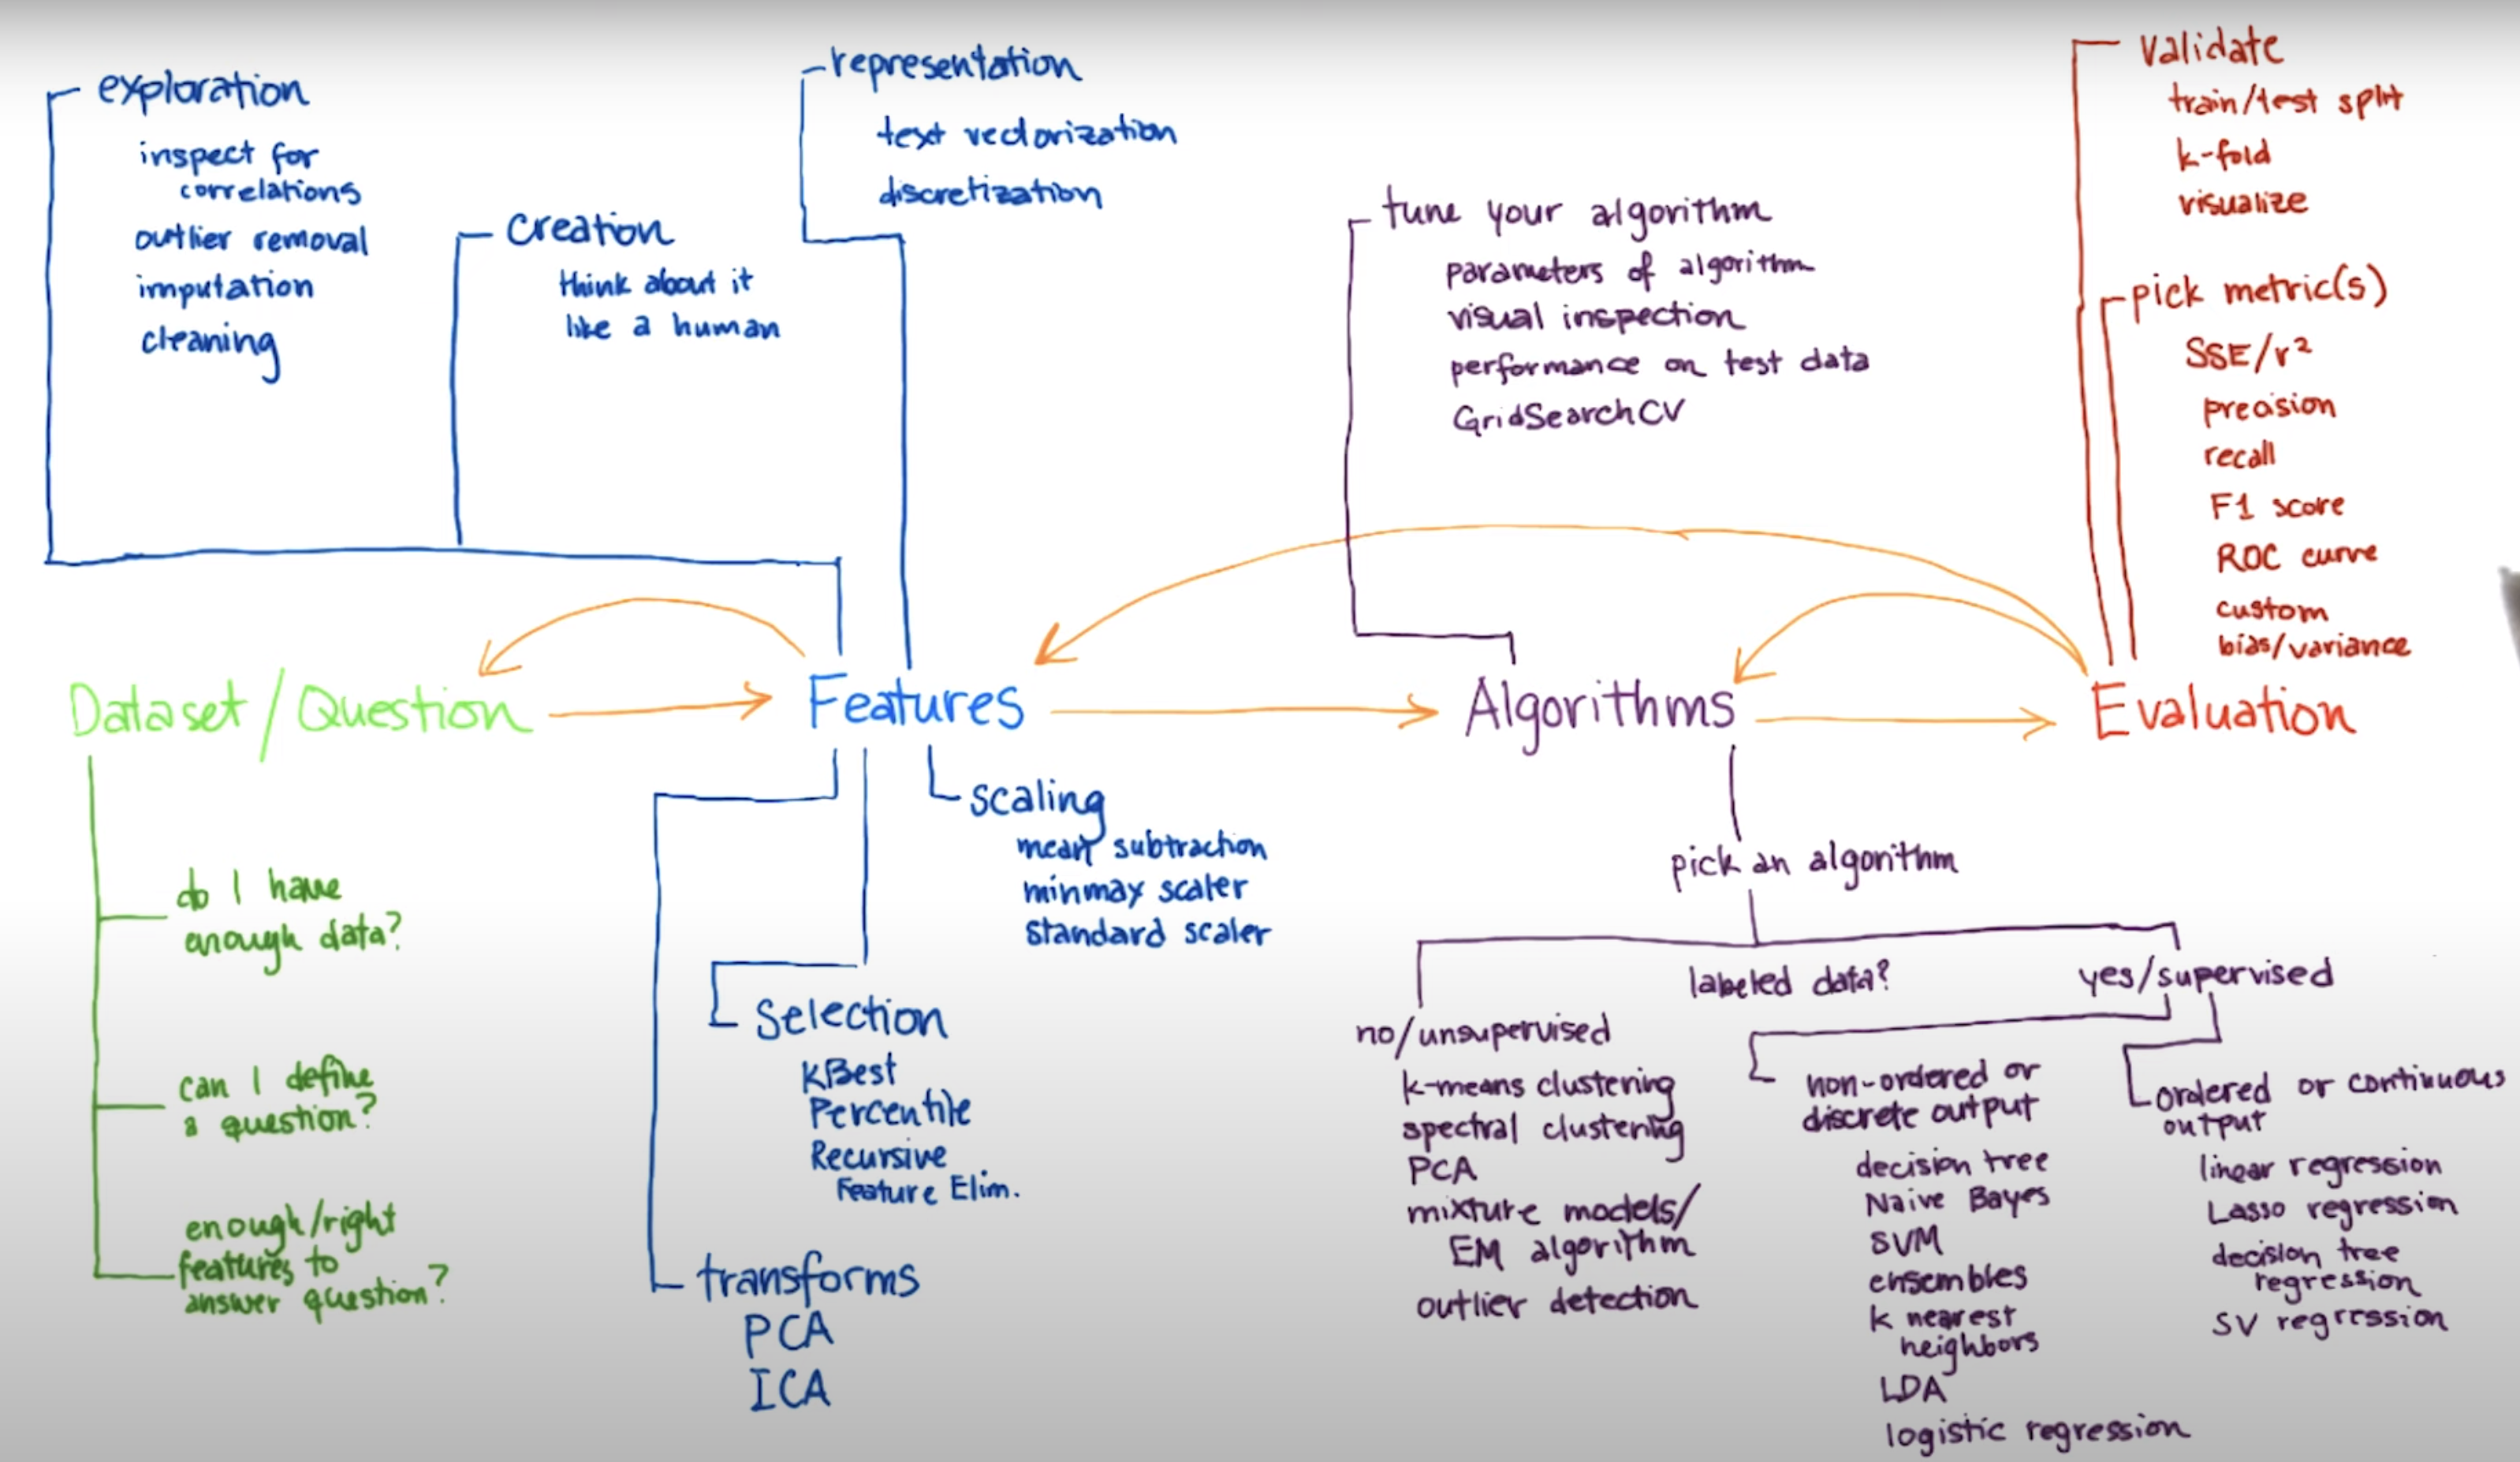

In [298]:
from IPython.display import Image
Image("img/udacity_ML_contents.png")

<a id='outliers'></a>
## 1. OUTLIERS

### 1.1. OUTLIERS - INTRODUCTION

#### TYPE OF OUTLIERS

- Outliers can be caused by sensor malfunction, data entry errors; which should be removed.
- Outliers from freak event => must be paid attention to and should not be omitted from the data.

#### BAD EFFECT OF OUTLIERS
- Problem for statistical analysis and modelling: Wrong prediction, worse inference
- Wrong data imputing, for example, outliers can greatly change the values of filled-missing data using the statistical method such as fillna by means.

#### OUTLIER REMOVAL TECHNIQUES
- Some techniques for outlier removal:
    + Gaussian model: 
        + Fit a Gaussian distribution on the data
        + Find values that have very low probability => can be considered anomalies using a set threshold.
        + Could be use for large dataset with many dimensions.
    + Boxplot of a normal distribution + The Tuckey Method
    + DBSCAN: Need to tune the parameters to get the "good" cluster
    + IsolationForest: 
        + Good for high dimensional dataset. 
        + Need to tune the parameters to get the "good" cluster
    
- [Good reference](https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf)

### 1.2. CASE STUDY 1

- Anomaly detection - supervised dataset from the file `data/anomaly_detection1.mat`.
- X: 2 features X1 and X2, y: binary class (0: normal and 1: anomaly observations).

In [636]:
### Load and process the data
mat = scipy.io.loadmat('data/anomaly_detection1.mat')
#access data through mat['X'] (or mat['Xval']) and mat['y']
X = mat['X']
y = mat['yval']
print(X.shape, y.shape)
### Make the dataframe for easy visualization
data = pd.DataFrame(X, columns = ['X1', 'X2'])
data['y'] = y
data.head(3)

(307, 2) (307, 1)


X1         X2  y
0  13.046815  14.741152  0
1  13.408520  13.763270  0
2  14.195915  15.853181  0

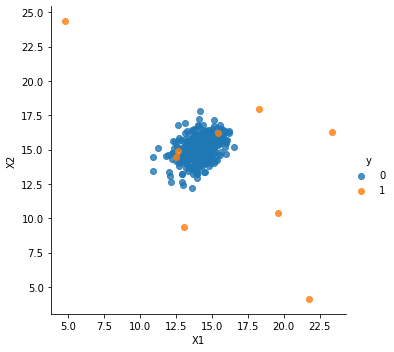

In [637]:
#### Visualization of the data
def scatterPlot(data):
    g = sns.FacetGrid(data = data, hue = 'y', height = 5) # Height (in inches) of each facet.
    g.map(plt.scatter, "X1", "X2", alpha = 0.8)
    g.add_legend()
    plt.show()
scatterPlot(data)

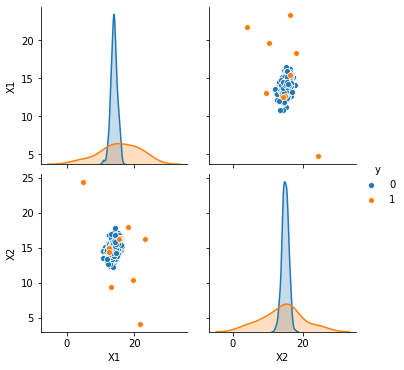

In [638]:
sns.pairplot(data, hue = 'y')
plt.show()

#### 1.2.1. BOXPLOT VISUALIZATION TO DETECT ANOMALY

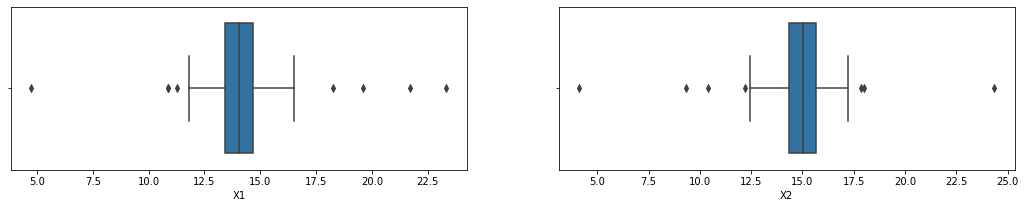

In [525]:
### boxplot => Check if data has outliers or not
fig = plt.figure(figsize = (18,3))
fig.add_subplot(1,2,1)
sns.boxplot(data['X1'])
fig.add_subplot(1,2,2)
sns.boxplot(data['X2'])
plt.show()

#### 1.2.2. APPLY THE TUCKEY METHOD TO DETECT AND REMOVE ANOMALY

In [599]:
def outlierLimits(Xi):
    """Define the threshold of the outlier
    Input: feature Xi
    Output: The lower and upper limit for outliers. 
    All the observation < lowerlimit or > upperlimit would be considered as anomaly"""
    
    Q1 = np.percentile(Xi, 25)
    Q3 = np.percentile(Xi, 75)
    ### Get the Interquartile range IQR
    IQR = Q3 - Q1
    low_limit = Q1 - 1.5*IQR
    up_limit = Q3 + 1.5*IQR
    return low_limit, up_limit

In [600]:
lowX1, upX1 = outlierLimits(data['X1'])
lowX2, upX2 = outlierLimits(data['X2'])
print("X1 limits", lowX1, upX1)
print("X2 limits", lowX2, upX2)

X1 limits 11.495123708843476 16.58373005428143
X2 limits 12.423402913270628 17.59298792070431


In [601]:
# The outliers are the observations that less than the (Q1 - 1.5*IQR) 
# or more than the (Q3 + 1.5*IQR) in either feature X1 or X2
outliers = data.query("((X1 < @lowX1) |(X1 > @upX1)) | ((X2 < @lowX2) |(X2 > @upX2))")
outliers

X1         X2  y
109  11.249155  15.132959  0
114  14.182026  17.833519  0
147  10.859401  14.479144  0
170  10.882213  13.461662  0
199  13.602797  12.202952  0
300  13.079310   9.347878  1
301  21.727134   4.126232  1
303  19.582573  10.411619  1
304  23.339868  16.298874  1
305  18.261188  17.978309  1
306   4.752613  24.350407  1

In [643]:
#### Put all together into the getOutlier function
def getOutliers(data, n_feature):
    """ Function to get the dataframe containing outliers.
    The outliers are the observations that less than the (Q1 - 1.5*IQR) 
    or more than the (Q3 + 1.5*IQR) in a feature Xi of the dataframe data
    - Input: dataframe contain i-1 features (X1 to Xi) and 
    the ground truth y binary classification (1: outliers, 0: non-outlier)
    - Use the helper function outlierLimits(Xi) to get the up/low limit for each feature Xi
    - Output: dataframe of outliers
    """
    condition = []
    for i in range(1, n_feature + 1):
        name = 'X' + str(i)
        lowX, upX = outlierLimits(data[name])
        condition.append('(({} < {}) |({} > {}))'.format(name, lowX, name, upX))
    condition_str = '|'.join(condition)
    #print(condition_str)
    outliers = data.query(condition_str)
    return outliers

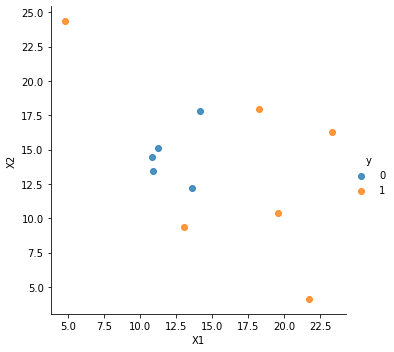

In [602]:
scatterPlot(outliers)
### Some wrong assignments could be seen as below when comparing to the ground truth.

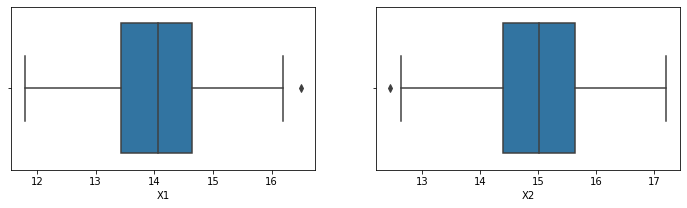

In [530]:
### Plotting the boxplot => Check again, there is no outliers after removal
data_outliers_removed = data.query("((X1 >= @lowX1) & (X1 <= @upX1)) & ((X2 >= @lowX2) & (X2 <= @upX2))")
fig = plt.figure(figsize = (12,3))
fig.add_subplot(1,2,1)
sns.boxplot(data_outliers_removed['X1'])
fig.add_subplot(1,2,2)
sns.boxplot(data_outliers_removed['X2'])
plt.show()

#### 1.2.3. APPLY DBSCAN METHOD TO DETECT AND REMOVE ANOMALY

In [531]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 1) # A little tricky to tune eps
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

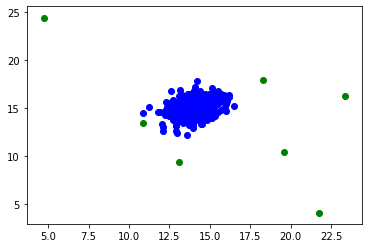

In [532]:
def plotCluster(pred, X):
    colors = ['blue', 'green'] #sns.color_palette('colorblind',10)
    for i, val in enumerate(pred):
        plt.scatter(X[i][0], X[i][1], color = colors[val])
plotCluster(dbscan.labels_, X)

In [533]:
dbscan.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [534]:
### Extract the outliers
indices = []
for i, x in enumerate(dbscan.labels_):
    if x != 0:
         indices.append(i)
indices

[170, 300, 301, 303, 304, 305, 306]

In [535]:
outliers = data.iloc[indices]
outliers

X1         X2  y
170  10.882213  13.461662  0
300  13.079310   9.347878  1
301  21.727134   4.126232  1
303  19.582573  10.411619  1
304  23.339868  16.298874  1
305  18.261188  17.978309  1
306   4.752613  24.350407  1

**=> DBSCAN seems to perform better on anomaly detection in this dataset**

#### 1.2.4. APPLY ISOLATIONFOREST TO DETECT AND REMOVE ANOMALY

In [493]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error

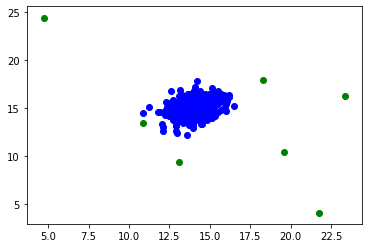

In [521]:
#iso = IsolationForest(contamination = 'auto', behaviour="new", random_state=42)
## Tune the contamination value [0, 0.5]
iso = IsolationForest(contamination = 0.02, behaviour="new", random_state=42)
y_pred = iso.fit_predict(X,y)
labels = []
for x in y_pred:
    if x == 1:
        labels.append(0)
    else:
        labels.append(1)
plotCluster(labels, X)

In [522]:
### Extract the outliers
indices = []
for i, x in enumerate(y_pred):
    if x == -1:
         indices.append(i)
outliers = data.iloc[indices]
outliers

X1         X2  y
170  10.882213  13.461662  0
300  13.079310   9.347878  1
301  21.727134   4.126232  1
303  19.582573  10.411619  1
304  23.339868  16.298874  1
305  18.261188  17.978309  1
306   4.752613  24.350407  1

### 1.3. CASE STUDY 2

#### OUTLIER REMOVAL STRATEGY USING LINEAR REGRESSION

- Including 3 steps: 
    + Step 1: train the data
    + Step 2: remove points with largest residual error (|real_val - predicted_val|)(~ 10% out the data points)
    + Step 3: re-train again and compare the r2 score of the train set.

**CASE STUDY DESCRIPTION**
- Predict net_worth according to age.
- Input file: 2 pickle files: "data/practice_outliers_ages.pkl" for age and "data/practice_outliers_net_worths.pkl" for net_worth.

**LOAD THE DATA**

In [376]:
### import neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# read matlab file
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [377]:
### Load and transform data
ages = pickle.load( open("data/practice_outliers_ages.pkl", "rb") )
net_worths = pickle.load( open("data/practice_outliers_net_worths.pkl", "rb") )

In [383]:
### Note: In this example, when using random_state = 42, there is no outlier in the test dataset!!!!

ages = np.reshape(np.array(ages),(len(ages), 1))
net_worths = np.reshape(np.array(net_worths), (len(net_worths), 1))
ages_train, ages_test, net_worths_train, net_worths_test = train_test_split(ages, net_worths, 
                                                                test_size = 0.1, random_state = 42)
print("Train:", len(ages_train))
print("Test:", len(ages_test))

Train: 90
Test: 10


**FUNCTIONS TO FIT, PLOT AND CLEAN DATA**

In [384]:
def fitData(ages_train, net_worths_train, ages_test, net_worths_test):
    """ Fit linear regression
        print out the slope, intercept and r2 score
        return the reg model"""
    reg = LinearRegression()
    reg.fit(ages_train, net_worths_train)
    print("Slope:", reg.coef_)
    print("Intercept:", reg.intercept_)
    print("r2 score, train data:", reg.score(ages_train, net_worths_train))
    print("r2 score, test data:", reg.score(ages_test, net_worths_test))
    return reg

def plotData(ages_train, net_worths_train, ages_test, net_worths_test, reg):
    """Plot the data (train/test) as scatter plot and plot the regression line"""
    plt.scatter(ages_train, net_worths_train, color = "blue", alpha = 0.5)
    plt.scatter(ages_test, net_worths_test, color = "green", alpha = 0.5)
    plt.plot(ages, reg.predict(ages))
    plt.xlabel("ages")
    plt.ylabel('net_worth')

def outlierCleaner(ages_train, net_worths_train, reg):
    """ Remove 10% of the train data with the largest residual errors 
        (difference between the prediction and the actual net worth)
        Return the new trainning data
    """
    cleaned_data = []
    preds = reg.predict(ages_train)
    for i in range(len(preds)):
        error = abs(preds.item(i) - net_worths_train.item(i))
        cleaned_data.append([ages_train.item(i), net_worths_train.item(i), error])
    ### sort the cleaned_data according to the residual error
    cleaned_data.sort(key = lambda x: x[2])
    cleaned_data = cleaned_data[:len(ages_train) - int(len(ages_train)/10)]
    ages, net_worths, _ = zip(*cleaned_data)
    ages = np.reshape(np.array(ages), (len(ages),1))
    net_worths = np.reshape(np.array(net_worths), (len(net_worths),1))
    
    return ages, net_worths

### OUTLIER REMOVAL PROCESS

Slope: [[5.07793064]]
Intercept: [25.21002155]
r2 score, train data: 0.4898725961751499
r2 score, test data: 0.8782624703664675


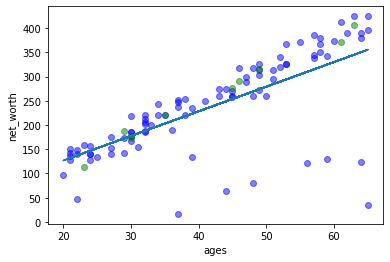

In [385]:
### Step 1: train the data
reg = fitData(ages_train, net_worths_train, ages_test, net_worths_test)
plotData(ages_train, net_worths_train, ages_test, net_worths_test, reg)

In [386]:
### Step 2: remove points with largest residual error (|real_val - predicted_val|)(~ 10% out the data points)
new_ages_train, new_net_worths_train = outlierCleaner(ages_train, net_worths_train, reg)
print(len(new_ages_train), len(new_net_worths_train))

81 81


Slope: [[6.36859481]]
Intercept: [-6.91861069]
r2 score, train data: 0.9513734907601892
r2 score, test data: 0.983189455395532


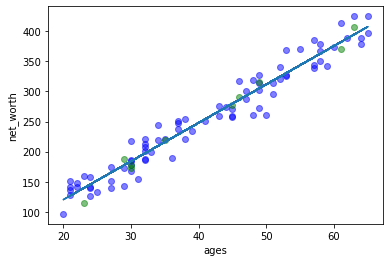

In [387]:
### Step 3: re-train again and compare the r2 score of the train set.
reg = fitData(new_ages_train, new_net_worths_train, ages_test, net_worths_test)
plotData(new_ages_train, new_net_worths_train, ages_test, net_worths_test, reg)

### 1.4. CASE STUDY 3

- Anomaly detection - supervised dataset from the file `data/anomaly_detection2.mat`.
- X: 2 features X1 and X2, y: binary class (0: normal and 1: anomaly observations).

In [609]:
mat2 = scipy.io.loadmat('data/anomaly_detection2.mat')

In [604]:
mat2

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 23:12:48 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[  6.65311366,  13.68970163,  17.55284534, ...,  -4.88402408,
           5.34933534,  17.35137235],
        [ -5.63054206, -18.93766731,  18.64462416, ...,  -2.87717344,
          -6.00942041,  19.21063612],
        [  9.72152507,  -9.98248898,  15.57143412, ...,   0.7275748 ,
          10.392975  ,   7.0859949 ],
        ...,
        [  5.42020917,  -5.10984522,  12.19219937, ..., -13.89942441,
           9.41801605,   1.84138358],
        [ 11.60473151,  -9.13417459,  19.58251695, ...,   1.01426524,
          -0.7840654 ,   6.2179038 ],
        [  9.49130218, -12.82373283,  -0.51710828, ...,  -9.044737  ,
           7.70413334,   3.74875986]]),
 'Xval': array([[ 18.27128267, -12.35926827,   5.00096952, ...,  -9.47667866,
         -25.92818273,   7.10862793],
        [ -3.19306995, -19.70582077,   6.52855559, ..., -10.96830111,
       

In [640]:
### Load and process the data
mat2 = scipy.io.loadmat('data/anomaly_detection2.mat')
#access data through mat['X'] (or mat['Xval']) and mat['y']
X = mat2['Xval']
y = mat2['yval']
print(X.shape, y.shape)
### Make the dataframe for easy visualization
colnames = ['X'+str(i) for i in range(1, len(X[0]) + 1)]
data = pd.DataFrame(X, columns = colnames)
data['y'] = y
data

(100, 11) (100, 1)


X1         X2         X3         X4         X5         X6  \
0   18.271283 -12.359268   5.000970   1.611472   1.088592  29.314410   
1   -3.193070 -19.705821   6.528556 -21.570858   3.050556  23.477503   
2   -5.256678 -12.918720  25.435141  -7.231568   3.647838  12.366550   
3   12.953176 -10.350333  19.857858 -24.424608   3.266105  30.445294   
4    3.763819  -5.728187  11.400169 -17.555297  -6.246576  16.155969   
..        ...        ...        ...        ...        ...        ...   
95  -0.928511 -22.950801  18.913328   4.279606 -11.798425  10.344052   
96   7.039219 -14.193847  18.055123 -16.635222   2.093759  32.706367   
97  -5.194642 -17.116599   3.526259  -9.626143 -10.062796  17.029116   
98   8.415389 -11.172920  35.802845   0.326202  -6.668745  17.642432   
99  16.347536   0.745160  26.122554 -23.388211 -11.970612  -3.562831   

           X7         X8         X9        X10        X11  y  
0   -8.313531  36.438338  -9.476679 -25.928183   7.108628  1  
1   -1.133420  12.688409 -10.968301  -1.198666   1.908441  0  
2   -6.512076   8.750902  -0.768755  -3.261094  13.729474  0  
3  -11.125842  12.815629   9.351355  -6.113624  17.627375  1  
4   -9.724758  16.996616  -5.168654   0.187994  11.401234  0  
..        ...        ...        ...        ...        ... ..  
95  -1.077825  17.325334 -10.480398   9.934596  10.532460  0  
96  -0.430254   8.994539  -1.397071  -1.711708  13.712861  0  
97 -10.339141  21.162552 -10.591517   2.007690   0.724487  0  
98   4.975742  -2.422990  -0.413698   4.078936  16.039303  0  
99  -9.562343  -2.476073 -12.025487  -5.240756  13.625056  0  

[100 rows x 12 columns]

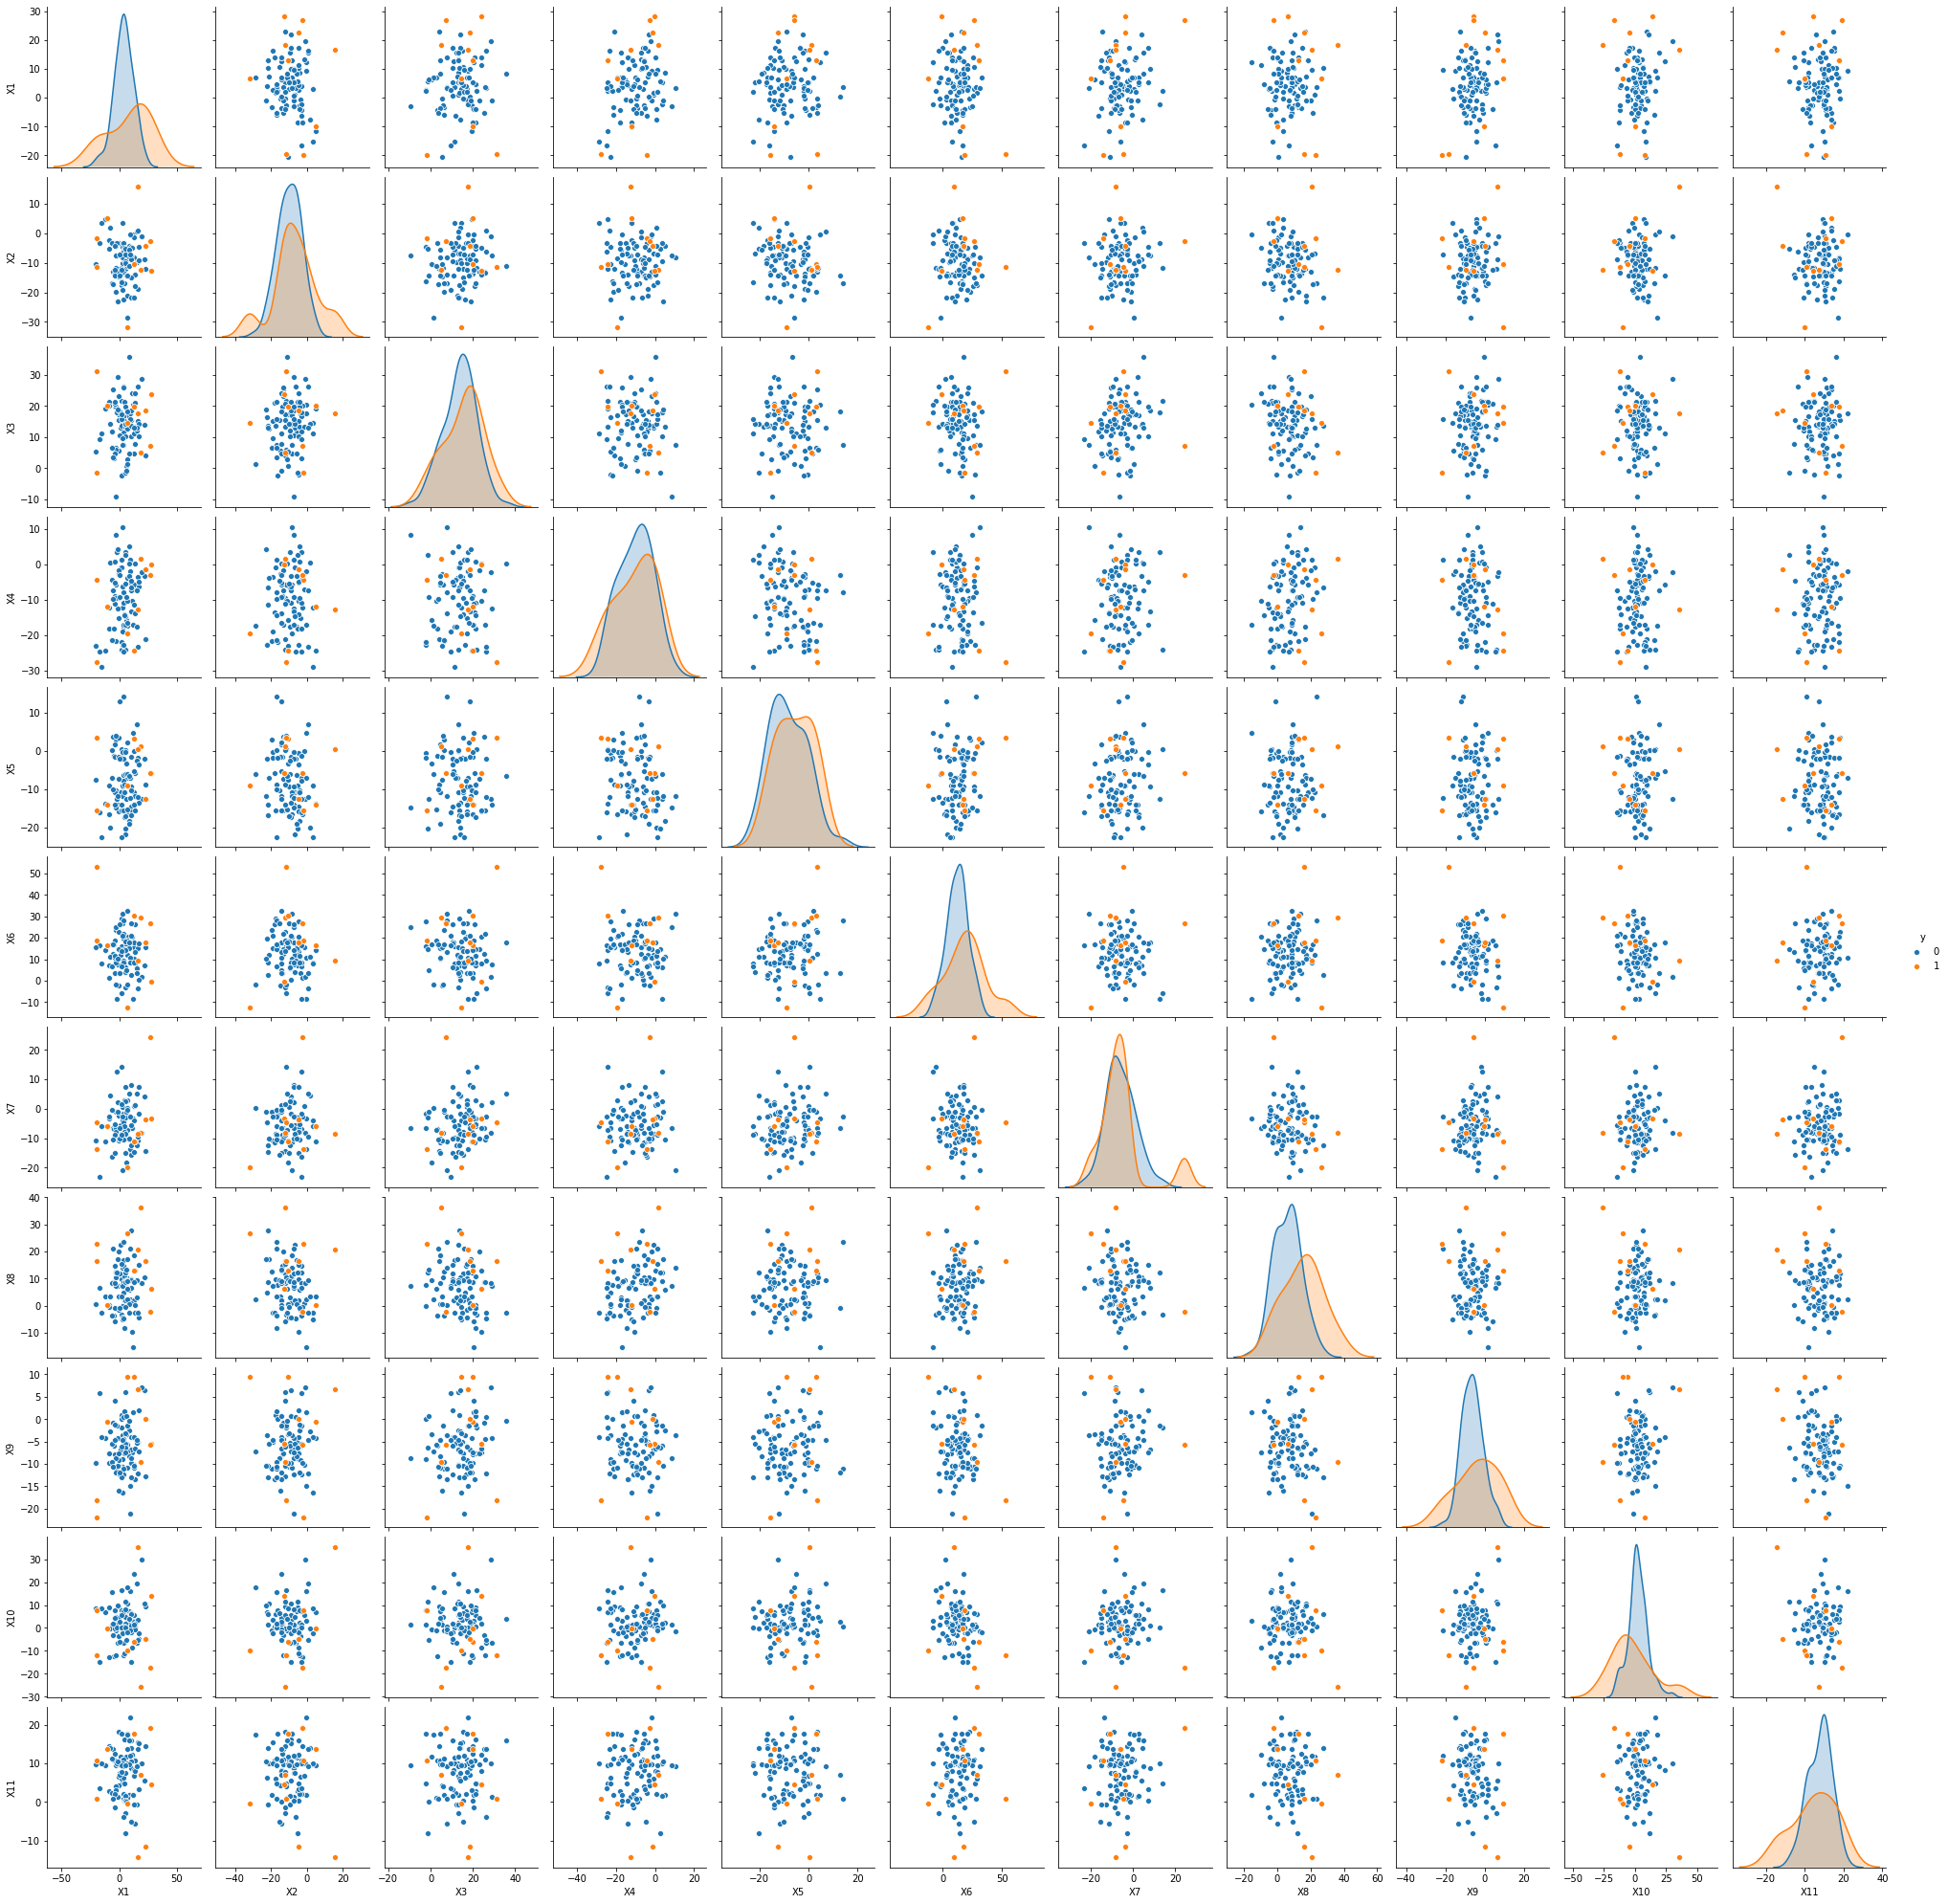

In [635]:
sns.pairplot(data, hue = 'y')
plt.show()

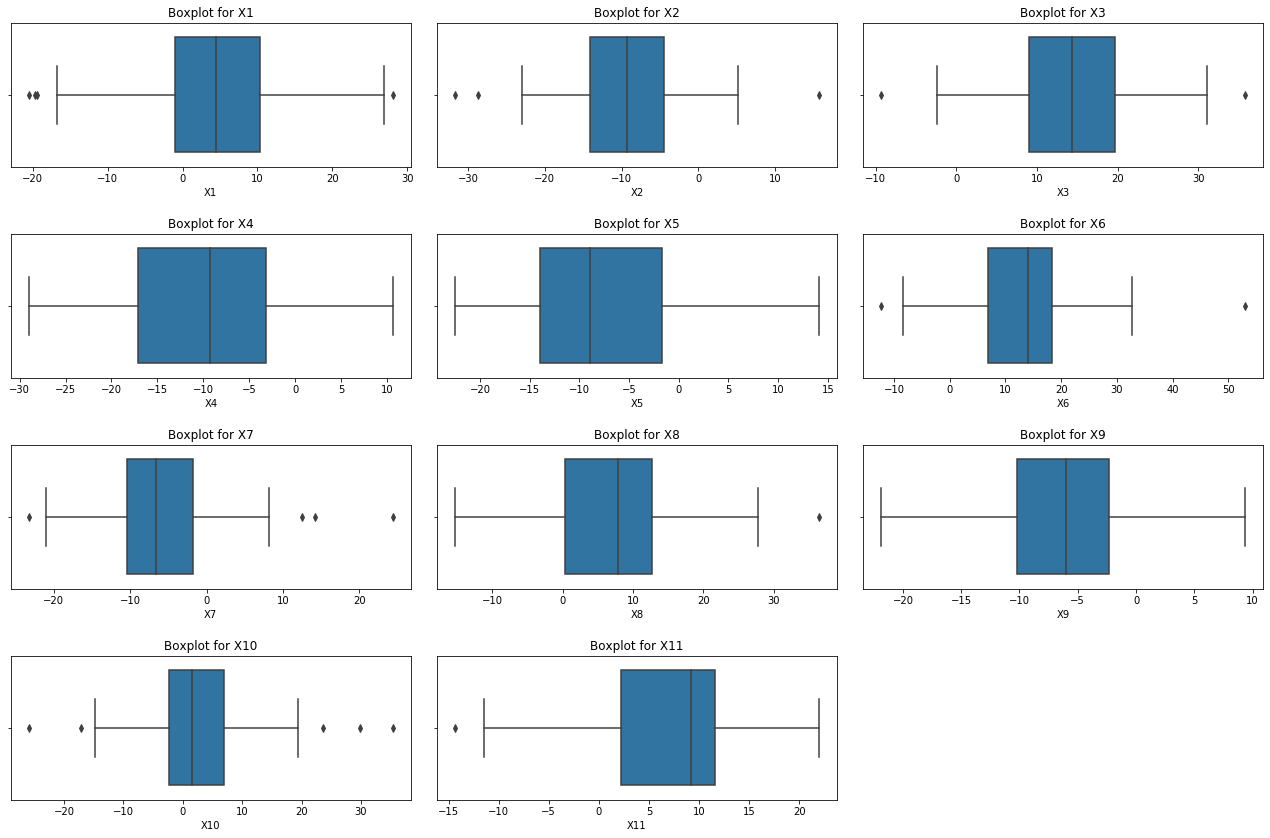

In [612]:
### boxplot => Check if data has outliers or not
fig = plt.figure(figsize = (18,12))
#for i in range(1, len(X[0]) + 1):
n = len(X[0]) + 1
i = 1
col_no = 3
row_no = int(np.ceil(n/3))
for i in range(1, n):
    name = 'X' + str(i)
#         print(name)
    fig.add_subplot(row_no, col_no, i)
    sns.boxplot(data[name])
    plt.gca().set_title('Boxplot for {}'.format(name))
    fig.tight_layout(pad = 2.0) # Set spacing between subplot
plt.show()

In [641]:
### IsolationForest
## Tune the contamination value [0, 0.5]
iso = IsolationForest(contamination = 0.3, behaviour = "new", random_state = 42)
y_pred = iso.fit_predict(X,y)
y_pred

### Extract the outliers
indices = []
for i, x in enumerate(y_pred):
    if x == -1:
         indices.append(i)
outliers = data.iloc[indices]
outliers

X1         X2         X3         X4         X5         X6  \
0   18.271283 -12.359268   5.000970   1.611472   1.088592  29.314410   
3   12.953176 -10.350333  19.857858 -24.424608   3.266105  30.445294   
6    2.278052 -11.677949  21.587127 -24.207612   0.506218  -5.678402   
7    2.619572  -4.594015  -2.102989 -22.800901  -0.476360  27.696357   
11  12.430198  -0.455364  20.266251 -17.034108   4.653034  -8.338388   
18  22.881904 -11.925738   4.140953 -20.987828  -8.852784  15.707430   
19  16.564435  15.684168  17.543187 -12.700243   0.537667   9.147008   
27   6.717709 -31.671866  14.436564 -19.513431  -9.096539 -12.313016   
29   2.317654 -16.138729  -2.438520 -22.001709  -1.869251  16.148561   
34   3.605881 -16.759012   7.557779  -7.916305  14.097630  28.030363   
38  28.086200 -12.640820  23.794977  -0.025830  -5.809310  -0.604883   
40   3.329000  -6.325586  26.238822 -24.681609  -2.125039   9.506604   
43  19.445392  -1.156025  28.635881  -2.249090 -12.516511   1.920206   
44   3.178912  -8.149793   7.521102  10.646447 -11.928446  31.368135   
46   9.171279  -0.341956  17.488647  -1.941110  -7.116328  10.487017   
50  -2.853362  -7.492498  -9.314258   8.440286 -14.883735  24.944690   
57  -7.547751   1.691775  14.209103   0.589555 -20.171660  10.907070   
59 -19.772252  -1.743640  -1.620125  -4.320884 -15.564298  18.614526   
60 -15.376311   3.372706  11.122477 -28.990815 -22.508399   7.811866   
64  -2.269675  -3.220117  17.857235   3.530407 -12.493028  -8.285689   
69   6.915816 -28.697342   1.291771 -17.431434  -6.003206  -1.718799   
70   5.719765  -5.133756  -1.408195   2.678322 -20.218204  14.482508   
71 -19.450379 -11.379227  31.067457 -27.643971   3.469073  53.003444   
77  10.298697 -21.918996  13.613666  -6.556268 -16.691227   2.714281   
86 -16.704553  -3.227649   9.390198 -24.627511 -15.962218  16.499297   
87 -20.522425 -10.309371   5.358083 -23.098095  -7.511395  15.796379   
88  26.904309  -2.613237   7.086004  -2.933628  -5.834784  26.503786   
92  22.649374  -4.424770  18.594174  -1.367620 -12.621821  17.711469   
98   8.415389 -11.172920  35.802845   0.326202  -6.668745  17.642432   
99  16.347536   0.745160  26.122554 -23.388211 -11.970612  -3.562831   

           X7         X8         X9        X10        X11  y  
0   -8.313531  36.438338  -9.476679 -25.928183   7.108628  1  
3  -11.125842  12.815629   9.351355  -6.113624  17.627375  1  
6   14.149213  -3.416211  -1.982982  16.541657   4.778478  0  
7   -6.689337  -0.247717  -8.944794   1.338357   4.767093  0  
11  -3.459005 -15.290246   1.563147   3.187978   1.720953  0  
18 -14.431426  16.495978 -12.725135   9.496500  14.383688  0  
19  -8.376931  20.664013   6.553167  35.369189 -14.351686  1  
27 -19.860870  26.672534   9.316382  -9.753093  -0.324571  1  
29  -1.606689   7.510348  -0.062125   7.731427  17.609595  0  
34  -2.539794  23.475966 -11.053082   0.813059   0.765865  0  
38  -3.439889   6.395132  -5.536944  13.933486   4.453282  1  
40  -2.637485  -4.766255   0.501291  -6.656608  -3.779854  0  
43  -8.102165   8.366544   7.003553  29.927104  10.037815  0  
44 -21.006218  13.991930  -3.567764  -1.386743   9.136932  0  
46 -13.613350   2.321988 -14.799604  15.923584  21.949361  0  
50  -6.425532   7.165935  -8.629454   1.630958   9.490456  0  
57   4.350103   3.275945  -2.721270  -0.385014  13.836005  0  
59 -13.851676  23.010457 -21.869114   7.652782  10.821318  1  
60  -5.988004  -2.590404  -4.070609   8.436154   9.975734  0  
64  12.548665  12.233716  -1.376321   0.305897   9.893352  0  
69   0.279567   2.315132  -7.185444  17.645144  17.335265  0  
70  -2.926307  12.237929  -6.332902  11.471502  -8.062086  0  
71  -4.488504  16.373326 -18.175129 -12.073440   0.704047  1  
77 -12.455699  27.776577 -13.015196   6.061207  13.934263  0  
86 -23.246868   6.750701   5.736810 -14.825341   3.439483  0  
87 -10.697049   0.544417  -9.760769   8.458753   9.698185  0  
88  24.356603  -2.233911  -5.797411 -17.233364  19.123261  1  
92  -3.645820 

In [613]:
data.query('y == 1')

X1         X2         X3         X4         X5         X6  \
0   18.271283 -12.359268   5.000970   1.611472   1.088592  29.314410   
3   12.953176 -10.350333  19.857858 -24.424608   3.266105  30.445294   
19  16.564435  15.684168  17.543187 -12.700243   0.537667   9.147008   
27   6.717709 -31.671866  14.436564 -19.513431  -9.096539 -12.313016   
38  28.086200 -12.640820  23.794977  -0.025830  -5.809310  -0.604883   
59 -19.772252  -1.743640  -1.620125  -4.320884 -15.564298  18.614526   
71 -19.450379 -11.379227  31.067457 -27.643971   3.469073  53.003444   
88  26.904309  -2.613237   7.086004  -2.933628  -5.834784  26.503786   
91 -10.044203   5.109982  19.976892 -11.953972 -14.045531  16.471698   
92  22.649374  -4.424770  18.594174  -1.367620 -12.621821  17.711469   

           X7         X8         X9        X10        X11  y  
0   -8.313531  36.438338  -9.476679 -25.928183   7.108628  1  
3  -11.125842  12.815629   9.351355  -6.113624  17.627375  1  
19  -8.376931  20.664013   6.553167  35.369189 -14.351686  1  
27 -19.860870  26.672534   9.316382  -9.753093  -0.324571  1  
38  -3.439889   6.395132  -5.536944  13.933486   4.453282  1  
59 -13.851676  23.010457 -21.869114   7.652782  10.821318  1  
71  -4.488504  16.373326 -18.175129 -12.073440   0.704047  1  
88  24.356603  -2.233911  -5.797411 -17.233364  19.123261  1  
91  -5.943807   0.168293  -0.508906  -0.172642  13.597351  1  
92  -3.645820  16.447036  -0.076373  -4.830322 -11.485781  1

In [644]:
#### Remove outlier using BoxPlot and Tuckey method
getOutliers(data, n_feature = 11)

X1         X2         X3         X4         X5         X6  \
0   18.271283 -12.359268   5.000970   1.611472   1.088592  29.314410   
6    2.278052 -11.677949  21.587127 -24.207612   0.506218  -5.678402   
19  16.564435  15.684168  17.543187 -12.700243   0.537667   9.147008   
27   6.717709 -31.671866  14.436564 -19.513431  -9.096539 -12.313016   
38  28.086200 -12.640820  23.794977  -0.025830  -5.809310  -0.604883   
43  19.445392  -1.156025  28.635881  -2.249090 -12.516511   1.920206   
49  12.588702 -14.416397  11.000215  -5.785579  -5.212062  17.977126   
50  -2.853362  -7.492498  -9.314258   8.440286 -14.883735  24.944690   
59 -19.772252  -1.743640  -1.620125  -4.320884 -15.564298  18.614526   
64  -2.269675  -3.220117  17.857235   3.530407 -12.493028  -8.285689   
69   6.915816 -28.697342   1.291771 -17.431434  -6.003206  -1.718799   
71 -19.450379 -11.379227  31.067457 -27.643971   3.469073  53.003444   
86 -16.704553  -3.227649   9.390198 -24.627511 -15.962218  16.499297   
87 -20.522425 -10.309371   5.358083 -23.098095  -7.511395  15.796379   
88  26.904309  -2.613237   7.086004  -2.933628  -5.834784  26.503786   
98   8.415389 -11.172920  35.802845   0.326202  -6.668745  17.642432   

           X7         X8         X9        X10        X11  y  
0   -8.313531  36.438338  -9.476679 -25.928183   7.108628  1  
6   14.149213  -3.416211  -1.982982  16.541657   4.778478  0  
19  -8.376931  20.664013   6.553167  35.369189 -14.351686  1  
27 -19.860870  26.672534   9.316382  -9.753093  -0.324571  1  
38  -3.439889   6.395132  -5.536944  13.933486   4.453282  1  
43  -8.102165   8.366544   7.003553  29.927104  10.037815  0  
49  -4.096474   2.052076  -3.952410  23.653837   8.280278  0  
50  -6.425532   7.165935  -8.629454   1.630958   9.490456  0  
59 -13.851676  23.010457 -21.869114   7.652782  10.821318  1  
64  12.548665  12.233716  -1.376321   0.305897   9.893352  0  
69   0.279567   2.315132  -7.185444  17.645144  17.335265  0  
71  -4.488504  16.373326 -18.175129 -12.073440   0.704047  1  
86 -23.246868   6.750701   5.736810 -14.825341   3.439483  0  
87 -10.697049   0.544417  -9.760769   8.458753   9.698185  0  
88  24.356603  -2.233911  -5.797411 -17.233364  19.123261  1  
98   4.975742  -2.422990  -0.413698   4.078936  16.039303  0

In [616]:
X.shape

(100, 11)

In [625]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 0.03) # A little tricky to tune eps
dbscan.fit(X)
print(dbscan.labels_ != -1)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


<a id = 'feature_scaling'></a>
## 2. FEATURE SCALING

### 2.1. WHICH ALGORITHMS NEED FEATURE SCALING

- Algorithms in which 2 dimensions affect the outcome will be affected by rescaling, such as:
    + SVM with rbf kernel
    + k-means clustering
    + PCA: scaling is critical for PCA. 
- Algorithms that don't need rescaling:
    + In linear regression, the coefficient and the feature always go together => no need to rescaling.
    + Decision Trees use vertical and horizontal lines so there is no trade off. 
    + Linear Discriminant Analysis (LDA) and Naive Bayes by nature don't need scaling.
- However, scaling could help decrease the running time by speeding up gradient descent => perform better, converge faster.
- Normalization: Deep learning algorithms often call for zero mean and unit variance. Regression-type algorithms also benefit from normally distributed data with small sample sizes.

### 2.2. SCALE VS STANDARDIZATION VS NORMALIZATION

- Scale: change the range of values, often set at 0 to 1  => Reserve: the distribution + the outliers
    + Min-max scaling: Scale the range of values to [0,1] => Reserve: the distribution + the outliers
        + x' = (x - min_x)/(max_x - min_x)
- Standardize: 
    + Shift the mean back to 0, variance to 1. Scaling is often implied
    + x' = (x - x_mean)/stdev => About 68% of the values will lie between -1 and 1.
- Normalization: Could have many meanings, should not be used or should be defined before using.
    + Mean normalization: The distribution will have value [-1,1] and mean = 0.

### 2.3. WHEN TO USE EACH FEATURE SCALING METHOD IN SCIKIT-LEARN PACKAGE?

- Start with **MinMaxScaler** since it reserve the distribution + the outliers.
- **RobustScaler**: reduce the effects of outliers, comparing to MinMaxScaler.
- **StandardScaler** change the distribution of the data => distort the relative distances between the feature values.
- **Normalizer**: rarely used. This one will normalize each sample observation (row), not the feature (column).

### 2.4. STEPS IN FEATURE SCALING
- Train/test split
- Fit the scaler on training set 
- Scale both train and test set

In [660]:
#### Load the example dataset
with open("data/housing_price.txt",'r') as f:
    data = f.read().split("\n")
X, y = [], []
for val in data:
    try:
        x1, x2, yi = val.split(",")
        X.append([float(x1), float(x2)])
        y.append(float(yi))
    except:
        print("End file")
print(len(X), len(y))

End file
47 47


In [696]:
### Step 1: Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), len(X_test), len(y_train), len(y_test))
X_train = np.array(X_train)
X_test = np.array(X_test)

37 10 37 10


In [698]:
### Step 2: Fit the scaler using StandardScaler
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler().fit(X_train)
### Step 3: Scale both train and test set
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

In [699]:
### Step 2: Fit the scaler using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_train_minmax_scale = minmax_scaler.fit_transform(X_train)
X_test_minmax_scale = minmax_scaler.transform(X_test)

In [702]:
### Step 2: Fit the scaler using RobustScaler
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler().fit(X_train)
X_train_robust_scale = robust_scaler.transform(X_train)
X_test_robust_scale = robust_scaler.transform(X_test)

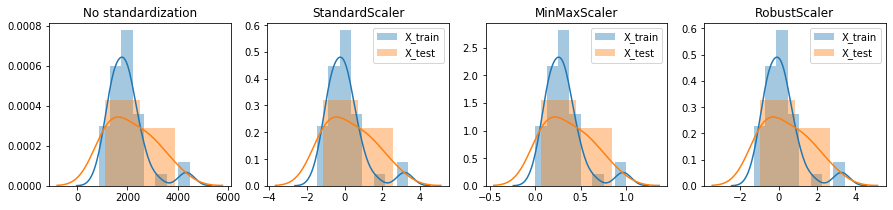

In [704]:
### displot => Check for the density of the data (lies in range 30 - 100)
plt.figure(figsize = [15, 3])
plt.subplot(1, 4, 1)
sns.distplot(X_train[:,0])
sns.distplot(X_test[:,0])
plt.title("No standardization")

plt.subplot(1, 4, 2)
sns.distplot(X_train_std[:,0])
sns.distplot(X_test_std[:,0])
plt.title("StandardScaler")
plt.legend(['X_train', 'X_test'])

plt.subplot(1, 4, 3)
sns.distplot(X_train_minmax_scale[:,0])
sns.distplot(X_test_minmax_scale[:,0])
plt.title("MinMaxScaler")
plt.legend(['X_train', 'X_test'])

plt.subplot(1, 4, 4)
sns.distplot(X_train_robust_scale[:,0])
sns.distplot(X_test_robust_scale[:,0])
plt.title("RobustScaler")
plt.legend(['X_train', 'X_test'])
plt.show()

### => In this case, all the scaler functions produce acceptable scaling result, with 
# no tranformation on the data distribution

##### Another example: Using not normal distribution example:

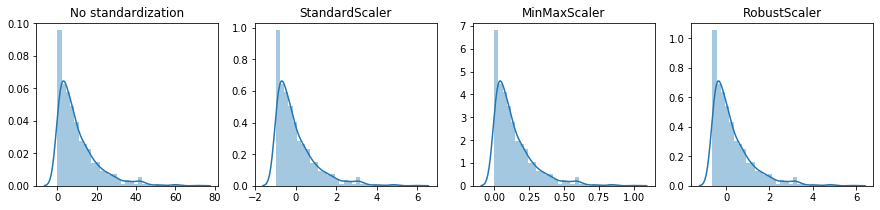

In [711]:
Xex = np.random.exponential(10, 1000).reshape(-1, 1)
print(Xex.shape)

### displot => Check for the density of the data (lies in range 30 - 100)
plt.figure(figsize = [15, 3])
plt.subplot(1, 4, 1)
sns.distplot(Xex)
plt.title("No standardization")

plt.subplot(1, 4, 2)
std_scaler_xex = StandardScaler().fit(Xex)
X_xex_std = std_scaler_xex.transform(Xex)
sns.distplot(X_xex_std)
plt.title("StandardScaler")

plt.subplot(1, 4, 3)
minmax_scaler_xex = MinMaxScaler()
X_xex_minmax_scale = minmax_scaler_xex.fit_transform(Xex)
sns.distplot(X_xex_minmax_scale)
plt.title("MinMaxScaler")

plt.subplot(1, 4, 4)

robust_scaler_xex = RobustScaler().fit(Xex)
X_xex_robust_scale = robust_scaler_xex.transform(Xex)
sns.distplot(X_xex_robust_scale)
plt.title("RobustScaler")
plt.show()

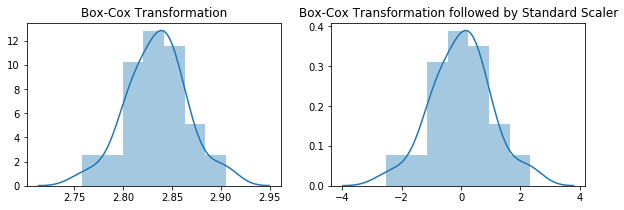

In [753]:
### Box-Cox => transform the data to normal distribution (See below for more detail about Box-Cox transformation)
from scipy import stats
X_train_normalized, _ = stats.boxcox(X_train[:,0])

plt.figure(figsize = [10, 3])
plt.subplot(1, 2, 1)
sns.distplot(X_train_normalized)
plt.title("Box-Cox Transformation")

plt.subplot(1, 2, 2)
### Apply StandardScaler on Box-Cox Transformation data
X_train_normalized= X_train_normalized.reshape(-1, 1)
std_scaler_1 = StandardScaler().fit(X_train_normalized)
X_train_std_ = std_scaler_1.transform(X_train_normalized)
sns.distplot(X_train_std_)
plt.title("Box-Cox Transformation followed by Standard Scaler")

plt.show()

### 2.5. NORMALIZATION - BOX-COX TRANSFORMATION

- Scaling just changes the range of the data, while normalization could mean change the dataset to a normal distribution.
- Normalizing the data to normal distribution should be used for a machine learning or statistics technique that assumes your data is normally distributed, such as t-tests, ANOVAs, linear regression, linear discriminant analysis (LDA), Gaussian naive Bayes.
- Box-Cox:
    + By default, only work for positive values.
    + The center of the transformation is the lambda value: Choose the optimal lambda value, ranging from -5 to 5, so that we get the best approximation of a normal distribution curve.
    + If lamda == 0, the transformation is log-tranformation: log(y_t), else: (y_t^lambda - 1)/lambda. According to the equation, when lambda == 1, the data shifts down but the shape doesnot change, which means the data is already normally distributed.
- Box-cox transformation is available through the stats package

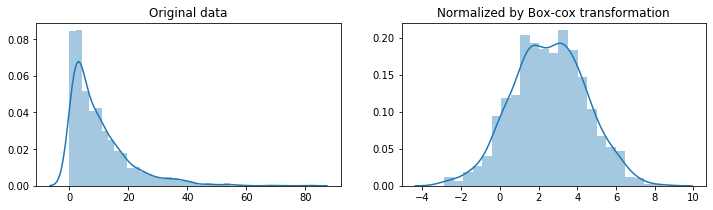

In [739]:
### Create example data: the exponential data
Xex = np.random.exponential(10, 1000)
#print(Xex.shape)
### Normalize the data
from scipy import stats
Xex_normalized, _ = stats.boxcox(Xex) ### (the output will be the Box-Cox transformed array and maxlog value)

### displot => Check for the density of the data 
plt.figure(figsize = [12, 3])
plt.subplot(1, 2, 1)
sns.distplot(Xex)
plt.title("Original data")

plt.subplot(1, 2, 2)
sns.distplot(Xex_normalized )
plt.title("Normalized by Box-cox transformation")
plt.show()

<a id = 'feature_selection'></a>
## 3. FEATURE SELECTION

### WHEN TO GET RID OF FEATURE

- It's noisy
- It causes overfitting
- It is strongly related (highly correlated) with a feature that's already present => See **Part 3** for checking multicollinearity.
- Additional feature slow down training/testing process

### 3.1. FEATURE SELECTION USING CLASSIFIER:
- Feature importance can be access through the model using the attribute `feature_importances_`:

    `clf.feature_importances_`

In [308]:
### Load and process the data
import random
with open ("data/college_admission.txt") as f:
    X, y, count = [], [], 0
    while f.readline():
        x = f.readline()
        try:
            x1, x2, yi = x.split("\n")[0].split(",")
            ### generate a random feature x3 which is either 0 or 1 to check for its feature importance
            x3 = random.randint(0, 1)
            
            X.append([float(x1), float(x2), x3])
            y.append(int(yi))
            count += 1
        except:
            print("Parsing error. Line: ", count)
    print(len(X), len(y))

## split train/test set
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(len(X_train), len(X_test), len(y_train), len(y_test))

50 50
40 10 40 10


In [309]:
#### Fit and predict the data with Decision Tree
from sklearn import tree
from sklearn.metrics import accuracy_score
## initialize the classifier
clf = tree.DecisionTreeClassifier()
## fit the data
clf = clf.fit(X_train, y_train)
#predict the data
y_pred = clf.predict(X_test)
print("Accuracy score of the prediction", accuracy_score(y_test, y_pred))

Accuracy score of the prediction 0.9


In [310]:
### Get a list of the relative importance of all the features being used using the attribute feature_importances_
clf.feature_importances_

array([0.55754476, 0.44245524, 0.        ])

**=> Both 2 features 1 and 2 are important for the prediction, but not feature 3 which has importance value = 0.**

In [311]:
sel_ = SelectFromModel(linear_model.LogisticRegression(C = 1, penalty = 'l1'))
scaler = StandardScaler()
scaler.fit(X_train)
sel_.fit(scaler.transform(X_train), y_train)

/opt/anaconda3/envs/data_analysis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [312]:
sel_.get_support()
# So True is for the features that lasso thought is important (non-zero features) 
# while False is for the features whose weights were shrinked to zero 
# and are not important according to Lasso.

array([ True,  True,  True])

In [313]:
selected_feat = ["feature 1", "feature 2", "feature 3"]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(np.sum(sel_.estimator_.coef_,axis = 0) == 0)))

total features: 3
selected features: 3
features with coefficients shrank to zero: 0


### 3.2. FEATURE SELECTION USING REGULARIZATION:

- [Ref](https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499)
- **Regularlization**: adding a penalty to the different parameters of the ML model to reduce the freedom of the model => avoid overfitting. In linear model regularization, the penalty is applied over the coefficients.
- Type of regularization: 
        + Lasso (L1): shrink some of the coefficients to zero.
        + Ridge (L2 regularization) does not shrink coefficients to zero.

#### Using the Lasso regularization classification problem to select features 

**CASE STUDY EXAMPLE:**

- A part of the [The BNP Paribas Cardif Claims Management dataset](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management)

In [314]:
### import necessary packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [315]:
data = pd.read_csv("data/paribas_claims.csv", nrows = 50000)
print(data.shape)
data.head(3)

(50000, 133)


ID  target        v1        v2 v3        v4        v5        v6        v7  \
0   3       1  1.335739  8.727474  C  3.921026  7.915266  2.599278  3.176895   
1   4       1       NaN       NaN  C       NaN  9.191265       NaN       NaN   
2   5       1  0.943877  5.310079  C  4.410969  5.326159  3.979592  3.928571   

         v8  ...      v122      v123      v124  v125      v126      v127  \
0  0.012941  ...  8.000000  1.989780  0.035754    AU  1.804126  3.113719   
1  2.301630  ...       NaN       NaN  0.598896    AF       NaN       NaN   
2  0.019645  ...  9.333333  2.477596  0.013452    AE  1.773709  3.922193   

       v128  v129      v130      v131  
0  2.024285     0  0.636365  2.857144  
1  1.957825     0       NaN       NaN  
2  1.120468     2  0.883118  1.176472  

[3 rows x 133 columns]

In [316]:
#### Select the numeric variables only
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(data.select_dtypes(include = numerics).columns)
data = data[numerical_vars]
data.shape

(50000, 114)

In [317]:
X_train, X_test, y_train, y_test = train_test_split(
                data.drop(labels=['target', 'ID'], axis=1),
                data['target'], test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((35000, 112), (15000, 112))

In [318]:
# Scaling the data, as linear models benefits from feature scaling
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))
sel_ = SelectFromModel(LogisticRegression(C = 1, penalty = 'l1'))
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

/opt/anaconda3/envs/data_analysis/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/envs/data_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/opt/anaconda3/envs/data_analysis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [319]:
sel_.get_support()
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 112
selected features: 79
features with coefficients shrank to zero: 33


In [320]:
removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

Index(['v11', 'v20', 'v29', 'v33', 'v37', 'v41', 'v42', 'v48', 'v49', 'v53',
       'v55', 'v62', 'v63', 'v64', 'v65', 'v67', 'v68', 'v81', 'v86', 'v87',
       'v88', 'v94', 'v95', 'v96', 'v97', 'v103', 'v104', 'v106', 'v115',
       'v121', 'v122', 'v126', 'v131'],
      dtype='object')

In [321]:
X_train_selected = sel_.transform(X_train.fillna(0))
X_test_selected = sel_.transform(X_test.fillna(0))
X_train_selected.shape, X_test_selected.shape

((35000, 79), (15000, 79))

In [322]:
def linearRegression(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    ### Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the train set
    regr.fit(X_train.fillna(0), y_train)
    y_test_pred = regr.predict(X_test.fillna(0))
    ### Compare MSE between training and testing
    print("The mean square error of training data: %.2f"%mean_squared_error(y_train, regr.predict(X_train.fillna(0))))
    print("The mean square error of testing data: %.2f"%mean_squared_error(y_test, y_test_pred))

In [323]:
linearRegression(X_train, y_train, X_test, y_test)

The mean square error of training data: 0.17
The mean square error of testing data: 0.17


In [324]:
def linearRegression(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    ### Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the train set
    regr.fit(X_train, y_train)
    y_test_pred = regr.predict(X_test)
    ### Compare MSE between training and testing
    print("The mean square error of training data: %.2f"%mean_squared_error(y_train, regr.predict(X_train)))
    print("The mean square error of testing data: %.2f"%mean_squared_error(y_test, y_test_pred))
linearRegression(X_train_selected, y_train, X_test_selected, y_test)

The mean square error of training data: 0.17
The mean square error of testing data: 0.17


<a id='multicolinearity'></a>
## 4. MULTICOLLINEARITY

- [Good reference](https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/)
- 2 or more independent variables are highly correlated with one another in a regression model.
- Examples: BMI and weight, height are multicollinearity since BMI is created from weight and height; temperature in oF and oC; "Dummy variable trap": need only 1 variable with 2 values 0/1 for married and single, but instead, use 2 dummy variables for both married and single status.
- Problem when has multicollinearity:
    + Difficult to distinguish the effect of each feature on the outcome => affect the interpretation of a ML model (understand why the prediction works, why a classifier choose a particular class => drive the business strategy). 
    
#### Methods to detect multicollinearity:

- Correlation matrix and scatter plots => show the bivariate relationship between the independent variables. 
- VIF is preferred as it can show the correlation of a variable with a group of other variables.

### 4.1. DETECTING MULTICOLLINEARITY THROUGH VISUALIZATION

In [647]:
### Load the example data to check the multicollinearity among variables
salary_df = pd.read_csv("data/salary.csv")
print(salary_df.shape)
salary_df.head(3)

(24, 5)


Gender  Age  Years of service  Education level  Salary
0       0   27               1.7                0   39343
1       1   26               1.1                1   43205
2       1   26               1.2                0   47731

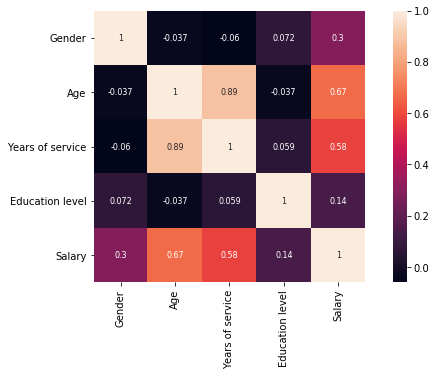

In [649]:
corr = salary_df.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr, square = True, annot = True, annot_kws = {'size':8})
plt.show()

**=> the ‘Age’ and ‘Years of service’ have a high positive correlation.**

##### Explore the correlation between 'Age' and 'Years of service':

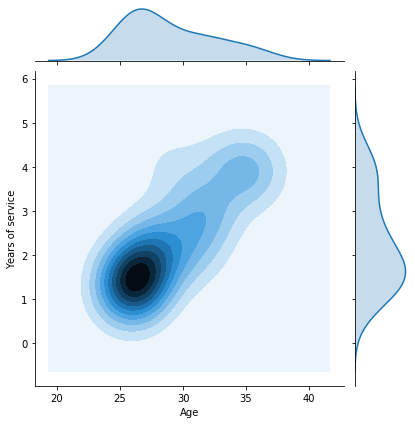

In [655]:
sns.jointplot(x = salary_df['Age'], y = salary_df['Years of service'],kind = 'kde')
plt.show()

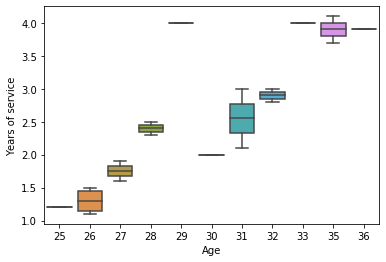

In [656]:
sns.boxplot(x = salary_df['Age'], y = salary_df['Years of service'])
plt.show()

### 4.2. DETECTING MULTICOLLINEARITY USING VARIABLE INFLATION FACTORS (VIF)

- VIF determines the strength of the correlation between the independent variables. 
- It is predicted by taking a variable and regressing it against every other variable.
- R square score is used to calculate the VIF value. R2 score is closer to 1 => the higher the multicollinearity is.

    VIF = 1/(1-R2)
    
   + VIF == 1: no correlation between the feature with other features
   + VIF > 5 or 10 (depends): high multicollinearity betwwen the feature with other features.

In [325]:
### import VIF from statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [645]:
def calculateVIF(df):
    """
    Calculate the VIF for each feature in the dataframe df using the VIF from statsmodels package
    Return the VIF value (as a dataframe) for each feature in the dataframe 
    """
    vif = pd.DataFrame()
    vif['features'] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    return vif

In [328]:
calculateVIF(salary_df.iloc[:,:-1])

features        VIF
0            Gender   2.207155
1               Age  13.706320
2  Years of service  10.299486
3   Education level   2.409263

**=> the ‘Age’ and ‘Years of service’ have a high VIF value, meaning they can be predicted by other independent variables in the dataset.**

### 4.3. FIXING MULTICOLLINEARITY

- **WHEN NEED TO FIX MULTICOLLINEARITY:**
    + When need to know the impact of each feature on the outcome. If multicollinearity is not present in the features you are interested in, then multicollinearity may not be a problem.
    + When need to reduce number of features.
- Dropping variables should be an iterative process starting with the variable having the **largest VIF** value because its trend is highly captured by other variables. 
- Note: After fixing, the VIF values for other variables would have reduced too, although to a varying extent.

In [329]:
### Example: combining "Age" and "Years of service" features
salary_df_reduced = salary_df.copy()
salary_df_reduced['Age_YearService'] = salary_df_reduced.apply(lambda x: x['Age']\
                                        - x['Years of service'], axis = 1)
salary_df_reduced = salary_df_reduced.drop(['Age', 'Years of service'], axis = 1)
salary_df_reduced.head(3)

Gender  Education level  Salary  Age_YearService
0       0                0   39343             25.3
1       1                1   43205             24.9
2       1                0   47731             24.8

In [330]:
calculateVIF(salary_df_reduced.iloc[:,:-1])

features       VIF
0           Gender  2.333204
1  Education level  2.507384
2           Salary  3.756664

<a id='pca'></a>
## 5. PRINCIPAL COMPONENT ANALYSIS (PCA)

### 5.1. WHAT IS PCA

Given a set of data points, PCA 
    + finds a new coordinate system that obtained from the old one by translation and rotation only.
    + moves the center of the coordinate system to the center of the data.
    + moves the x axis into the principle axis of variation (where the most variation is)
    + moves the other axes into the orthogonal less important direction of variation.

- Principal component of a dataset is the direction that has the largest variance that retains maximum amount of information in original data.

### 5.2. WHEN TO USE PCA

- Identify the latent features driving the pattern in the data
- Dimensionality reduction: 
    + help to visualize high-dimensional data
    + reduce noise
    + make the ML algorithms (regression, classification) work better with fewer features. For example: PCA for Facial recognition (eigenfaces dataset).
- Scaling is critical while performing Principal Component Analysis(PCA). PCA tries to get the features with maximum variance and the variance is high for high magnitude features. This skews the PCA towards high magnitude features.

**WHY PCA IS GOOD FOR FACIAL RECOGNITION**

- Pictures of faces generally have high input dimensionality (may pixels).
- Faces have general patterns that could be captured in smaller number of dimensions.

### 5.3. EXAMPLE FOR ML PROCESS USING PCA FOLLOWED BY SVM

- STEP 1: Prepare the data - Split data into train/test set
- STEP 2: PCA fit the train set, PCA transform the train set
- STEP 3: SVC fit on the train set
- STEP 4: PCA transform on the test set
- STEP 5: SVC predict on the test set

### 5.4. HOW MANY PCs TO USE?

- Train on different number of PCs, and see how accuracy responds.
- Use the cut-off value where adding more PCs doesn't get much more discrimination.

### 5.5. CASE STUDY: EIGENFACES

In [331]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

#### STEP 1: Prepare the data - Split data into train/test set

In [332]:
### Loading the eigenfaces data
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.4)

In [333]:
### Process the eigenfaces data
X, y = lfw_people.data, lfw_people.target
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train.shape, X_test.shape

((966, 1850), (322, 1850))

In [355]:
### Meta data of the eigenfaces data
n_samples, h, w = lfw_people.images.shape
n_features = X.shape[1]
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print(n_samples, n_features, n_classes)

1288 1850 7


**=> The number of features is more larger than the number of sample => Need to reduce the data** 

#### STEP 2: PCA fit the train set - PCA transform the train set

In [356]:
### Performing PCA unsupervised feature extraction/dimensionality reduction
from sklearn.decomposition import PCA as RandomizedPCA
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

n_components = 150 # optimized value
### Explore the good n_components value:
#n_component_list = [10, 15, 25, 50, 100, 150, 250]

print("Extracting the top {} eigenfaces from {} faces".format(n_components, X_train.shape[0]))
start_time = time()
pca = RandomizedPCA(n_components = n_components, whiten = True)
pca.fit(X_train)
print("... done in {0:.3f}s".format(time() - start_time))

Extracting the top 150 eigenfaces from 966 faces
... done in 0.078s


In [357]:
#### Explore the PCA
print(pca.components_.shape)
print("PCA first component:", pca.components_[0])
print("PCA second component:", pca.components_[1])
### the first PC giving the direction of maximal variance, 
# second PC has second-largest variance
print("How much of the variance is explained by the 1st principal component:", pca.explained_variance_[0])
print("How much of the variance is explained by the 2nd principal component:", pca.explained_variance_[1])

(150, 1850)
PCA first component: [-0.00685209 -0.00752694 -0.00918908 ... -0.01433786 -0.0129419
 -0.01188292]
PCA second component: [ 0.02304094  0.0215521   0.02275391 ... -0.0440019  -0.04318584
 -0.04226126]
How much of the variance is explained by the 1st principal component: 501417.97
How much of the variance is explained by the 2nd principal component: 391794.8


In [358]:
### PCA transform the train set
print("Projecting the input data on the eigenfaces orthonormal basis")
start_time = time()
X_train_pca = pca.transform(X_train)
print("... done in {0:.3f}s".format(time() - start_time))

Projecting the input data on the eigenfaces orthonormal basis
... done in 0.008s


#### STEP 3: SVC fit on the train set

In [359]:
### Train a SVM classification model
print("Fitting the classifier to the training set")
params = {'C':[1e3, 5e3, 1e4, 5e4, 1e5]} 
          #'gamma': ['auto', 'scale'], 
          #'kernel':['linear', 'rbf']}
start_time = time()
X_train_pca = pca.transform(X_train)
clf = GridSearchCV(SVC(class_weight = 'balanced', kernel = 'rbf', gamma = 'scale'), params, cv = 5)
clf.fit(X_train_pca, y_train)
print("... done in {0:.3f}s".format(time() - start_time))
print("Best estimator found by grid search:", clf.best_estimator_)

Fitting the classifier to the training set
... done in 9.892s
Best estimator found by grid search: SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### STEP 4: PCA transform on the test set

In [360]:
### transform on the test set
X_test_pca = pca.transform(X_test)

#### STEP 5: SVC predict on the test set

In [361]:
print("Predicting the people names on the testing set")
start_time = time()
y_pred = clf.predict(X_test_pca)
print("... done in {0:.3f}s".format(time() - start_time))


Predicting the people names on the testing set
... done in 0.065s


In [362]:
y_pred

array([3, 3, 6, 3, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 3,
       3, 3, 3, 1, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1,
       1, 1, 4, 3, 3, 3, 3, 3, 0, 3, 6, 2, 3, 3, 5, 3, 1, 1, 3, 4, 3, 3,
       6, 4, 1, 3, 1, 6, 3, 3, 3, 2, 1, 6, 3, 4, 3, 0, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 6, 3, 1, 1, 3, 1, 1, 6, 6, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1,
       4, 1, 3, 3, 3, 1, 3, 4, 1, 3, 1, 3, 3, 0, 3, 4, 4, 3, 1, 3, 6, 6,
       6, 3, 2, 4, 3, 3, 1, 6, 2, 2, 5, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3,
       3, 3, 6, 3, 1, 3, 6, 5, 5, 1, 3, 1, 5, 1, 3, 3, 1, 1, 3, 1, 5, 6,
       3, 2, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 6, 3, 3, 6,
       3, 6, 3, 2, 1, 2, 3, 1, 6, 2, 3, 1, 3, 4, 3, 3, 3, 3, 3, 3, 3, 1,
       3, 3, 3, 1, 6, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 1, 6, 3, 3, 3, 3, 4,
       2, 3, 3, 0, 3, 3, 3, 3, 4, 3, 3, 1, 3, 4, 3, 1, 6, 3, 3, 3, 2, 1,
       3, 3, 3, 1, 3, 6, 1, 1, 3, 3, 6, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 0,
       3, 3, 3, 4, 3, 3, 5, 3, 3, 1, 4, 3, 3, 4, 3,

#### STEP 6: Validation

In [363]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [364]:
print(classification_report(y_test, y_pred, target_names = target_names))
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.46      0.63        13
     Colin Powell       0.81      0.87      0.84        60
  Donald Rumsfeld       0.94      0.59      0.73        27
    George W Bush       0.78      0.98      0.87       146
Gerhard Schroeder       0.95      0.72      0.82        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       1.00      0.72      0.84        36

        micro avg       0.83      0.83      0.83       322
        macro avg       0.93      0.69      0.77       322
     weighted avg       0.86      0.83      0.82       322

[[  6   2   0   5   0   0   0]
 [  0  52   0   8   0   0   0]
 [  0   2  16   9   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   6  18   0   0]
 [  0   3   0   4   1   7   0]
 [  0   1   1   8   0   0  26]]


**Visualization of the prediction result using pylab**

In [365]:
import pylab as pl

In [366]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [367]:
def title(y_pred, y_test, target_names, i):
    """Make label for each image from target_names
    Each label would be as followed: 
        Predicted: LastName
        True     : LastName
    
    """
    pred_name = target_names[y_pred[i]].split(' ')[-1] # get only the last name from label
    true_name = target_names[y_test[i]].split(' ')[-1]
    return 'Predicted: {}\nTrue      : {}'.format(pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]
prediction_titles[:2]

['Predicted: Bush\nTrue      : Bush', 'Predicted: Bush\nTrue      : Bush']

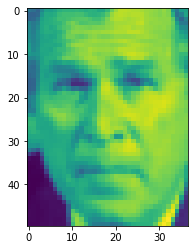

In [368]:
pl.imshow(X_test[0].reshape((h, w)))
pl.show()

In [369]:
def plot_image(images, titles, h, w, n_row = 3, n_col = 4):
    """Plot the images
    """
    pl.figure(figsize = (1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom = 0, left = .01, right = .99, top = .90, hspace = .35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap = pl.cm.gray)
        pl.title(titles[i], size = 12)
        pl.xticks(())
        pl.yticks(())

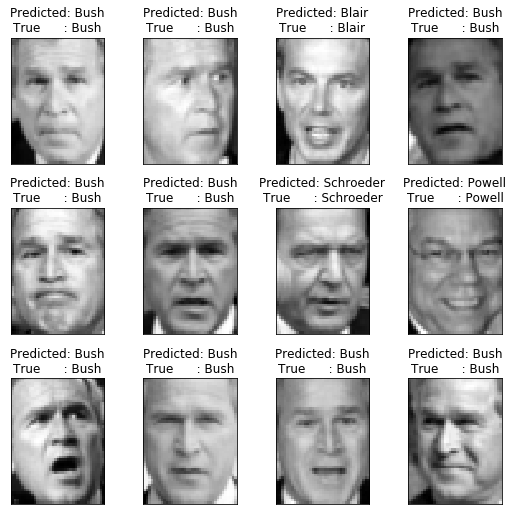

In [370]:
plot_image(X_test, prediction_titles, h, w)

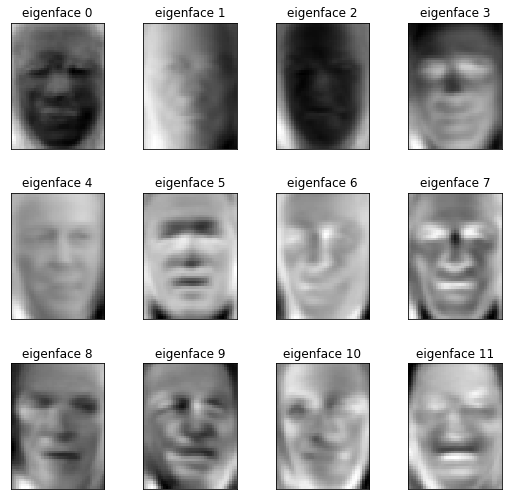

In [372]:
# reshape the pca components for visualization 
eigenfaces = pca.components_.reshape((n_components, h, w))

### display the eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_image(eigenfaces, eigenface_titles, h, w)

<a id='feature_engineering'></a>
## 6. FEATURE ENGINEERING

Type of feature engineering:
- Indicator variables
- Interaction features
- Feature representation
- External data
- Error analysis to explore more features

### 6.1. INDICATOR VARIABLES

- Created from thresholds:
    + Create an indicator variable `age >= 21` to distinguish consumers that could drink alcohol.
- Created from  multiple features: 
    + For predicting real-estate prices: an indicator variable for `house >= 2 beds and 2 baths` => good for rental
- Created from special events: 
    + Weekly sales for e-commerce site: an indicator variable for Black Friday and Christmas
- Created from groups of classes:
    + Example: Analyzing website conversions: and indicator for paid or free traffic source.

### 6.2. INTERACTION FEATURES

Some features can be combined to provide more information than they would as individuals.

- Sum of 2 features:
    + Combine `blue_pen_sale` and `black_pen_sale` to overall `pen_sale`.
- Difference between 2 features: 
    + Combine `house_built_date` and `house_purchase_date` to create `house_age`.
- Product of 2 features: 
    + Combine `price` and `conversion` to create `earnings`.
- Quotient of 2 features::
    + Devide `clicks` by `impressions` to create `click_through_rate` to compare across campaigns of different volume.

### 6.3. FEATURE REPRESENTATION

Try to represent data in a different way to gain more information.

- Date and time features:
    + Extract `purchase_datetime` to get `purchase_dayOfWeek`, `purchase_hourOfDay` or `purchases_over_last_30days`.
- Numeric to categorical mappings: 
    + Divide `years_in_school` into `elementary_school`, `middle_school` and `high_school`.
- Grouping sparse classes: 
    + Combine similar classes with low sample counts into a single `other1` class.
- Create dummy variables:
    + Transbform categorical features into dummy variables. Always do after grouping sparse classes.

### 6.4. EXTERNAL DATA

Bring in external data.

- Time series data:

- External API's: 
    + Create features using external API's, such as the Microsoft Computer Vision API can return the number of faces from an image.
- Geocoding: 
    + Change `address` into `latitude` and `longitude` => classify into `region` or `local demographics` (such as `median_income_within_2_miles`). 
    + [Useful extra dataset](https://www.precisely.com/data-guide).
- Other sources of the same data:
    + Example: Way to track a FB ad campaign? Combine FB tracking, Google Analytics, another 3rd-party software.

### 6.5. ERROR ANALYSIS

- Need to perform after training the first model => Analyze the misclassifier or high error data point => Think of next step for improvement: 
    + collecting more data
    + splitting the problem apart
    + engineering new feature to address errors
- Steps for error analysis
    + This is typically a manual process => Start with larger errors
    + Segment the data and compare the average error within each segments => Can create indicator variables for segments with the higher errors.
    + Run an unsupervised clustering algorithm on the misclassified data points => easier to spot the pattern => understand why/what makes the error.
    + Ask colleagues/domain experts.